<a href="https://colab.research.google.com/github/elfaizrekia/tree_classification_prjt/blob/master/prj_tr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Exam: Image Processing**
## **Tree Species Classification**



**1.**   **objectif**



L’objectif de ce projet est de mettre en œuvre et de comparer différentes méthodes de classification afin de reconnaître automatiquement les espèces d’arbres à partir de données issues de nuages de points 3D, en exploitant
des approches multi-vues et d’apprentissage supervisé.

**2.Acquisition et Préparation des Données**




*   **Téléchargement de jeu de données**

In [3]:
!pip -q install open3d==0.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00


In [4]:
import os
os.environ["OPEN3D_RENDERING_SOFTWARE_ONLY"] = "1"

In [5]:
# === One-shot Colab cell: load + visualize a point cloud sample ===
from pathlib import Path
import re, math, random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import open3d as o3d

# --------- CONFIG ---------
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")
READABLE_EXTS = {".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".txt", ".csv"}

# --------- Robust .pts reader ---------


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

READABLE_EXTS = {".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".txt", ".csv"}

# --------- Robust .pts reader ---------
def _fast_is_number(tok: str):
    return bool(re.match(r"^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$", tok))

def read_pts_custom(path: Path, max_lines=None):
    xs, ys, zs = [], [], []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f if max_lines is None else (l for _, l in zip(range(max_lines), f))
        first_non_comment = None
        for line in lines:
            line = line.strip()
            if not line or line.startswith("#") or line.startswith("//"):
                continue
            if first_non_comment is None:
                toks = re.split(r"[,\s]+", line)
                if len(toks) == 1 and toks[0].isdigit():
                    first_non_comment = "header_count_skipped"
                    continue
                else:
                    first_non_comment = "data"
            toks = re.split(r"[,\s]+", line)
            nums = [t for t in toks if _fast_is_number(t)]
            if len(nums) < 3:
                continue
            x, y, z = float(nums[0]), float(nums[1]), float(nums[2])
            xs.append(x); ys.append(y); zs.append(z)
    if not xs:
        raise ValueError(f".pts sans points exploitables: {path}")
    pts = np.column_stack([xs, ys, zs]).astype(np.float64)
    mask = np.isfinite(pts).all(axis=1)
    pts = pts[mask]
    if len(pts) == 0:
        raise ValueError(f".pts vide après filtrage: {path}")
    return pts


*   **Visualisation de données**


>  Visualisations 2D des nuages de points:

1️⃣ Heatmap 2D (densité de points projetée sur un plan):



Nombre de points chargés : (109543, 3)


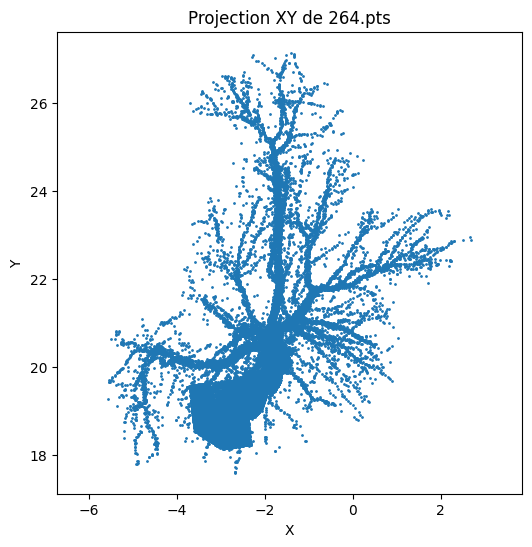

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
 # --------- Robust .pts reader ---------
def read_pts(filename):
    """
    Lit un fichier .pts (souvent avec des entêtes ou balises non numériques)
    et en extrait uniquement les coordonnées numériques (x, y, [z]).
    """
    return np.loadtxt(str(filename), comments=("version:", "n_points:", "{", "}"))

# ---------- Sample loading & visualization ----------
# Cherche un fichier .pts dans DATA_ROOT (ajuste le chemin selon ta structure)
sample = next(DATA_ROOT.rglob("*.pts"), None)
if sample is None:
    raise FileNotFoundError("Aucun fichier .pts trouvé sous DATA_ROOT")

# Lecture
points = read_pts(sample)
print(f"Nombre de points chargés : {points.shape}")

# 2D Visualization (projection XY)
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], s=1)
plt.title(f"Projection XY de {sample.name}")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

# 3D Visualization avec Open3D
# On suppose que le nuage est 3D (points[:, :3]), sinon on adapte
pcd = o3d.geometry.PointCloud()
if points.shape[1] >= 3:
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
else:
    raise ValueError("Le nuage de points n'a pas au moins 3 dimensions")

o3d.visualization.draw_geometries([pcd])

2️⃣ Histogrammes / KDE (distribution des coordonnées):

Nombre de fichiers trouvés : 33
Exemple : [PosixPath('/content/drive/MyDrive/trees_dataset/Dataset_/Ash/264.pts'), PosixPath('/content/drive/MyDrive/trees_dataset/Dataset_/Ash/250.pts'), PosixPath('/content/drive/MyDrive/trees_dataset/Dataset_/Ash/45.pts'), PosixPath('/content/drive/MyDrive/trees_dataset/Dataset_/Ash/184.pts'), PosixPath('/content/drive/MyDrive/trees_dataset/Dataset_/Ash/159.pts')]
Fichier choisi : /content/drive/MyDrive/trees_dataset/Dataset_/Ash/264.pts


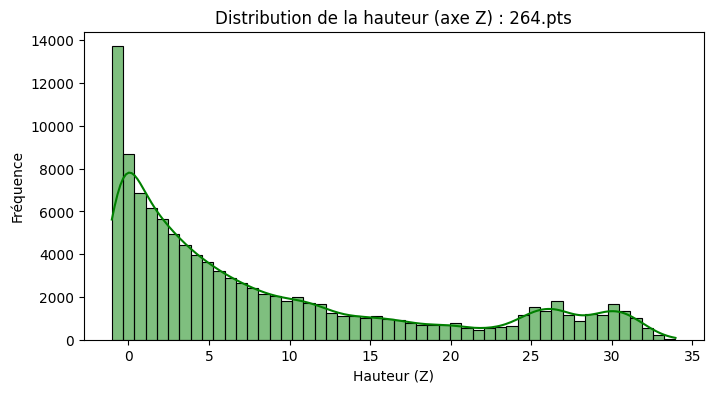

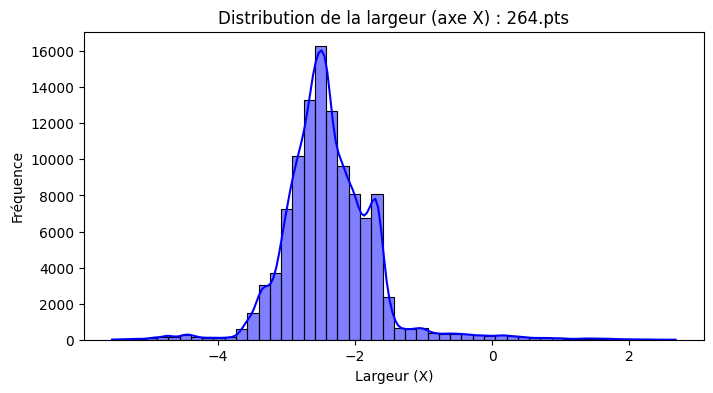

In [ ]:
from pathlib import Path

DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")

# Cherche tous les fichiers .pts
files = list(DATA_ROOT.rglob("*.pts"))
print("Nombre de fichiers trouvés :", len(files))
print("Exemple :", files[:5])
sample = files[0]   # prend le premier fichier trouvé
print("Fichier choisi :", sample)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

points = np.loadtxt(sample)   # lecture du fichier choisi
z = points[:,2]               # axe Z = hauteur

plt.figure(figsize=(8,4))
sns.histplot(z, kde=True, bins=50, color="green")
plt.title(f"Distribution de la hauteur (axe Z) : {sample.name}")
plt.xlabel("Hauteur (Z)")
plt.ylabel("Fréquence")
plt.show()
x = points[:,0]

plt.figure(figsize=(8,4))
sns.histplot(x, kde=True, bins=50, color="blue")
plt.title(f"Distribution de la largeur (axe X) : {sample.name}")
plt.xlabel("Largeur (X)")
plt.ylabel("Fréquence")
plt.show()

3️⃣ Cross-section (coupe à une hauteur donnée):

Fichier utilisé : /content/drive/MyDrive/trees_dataset/Dataset_/Ash/264.pts
Hauteur cible z0=4.64 | épaisseur totale=0.50 | points retenus=2653


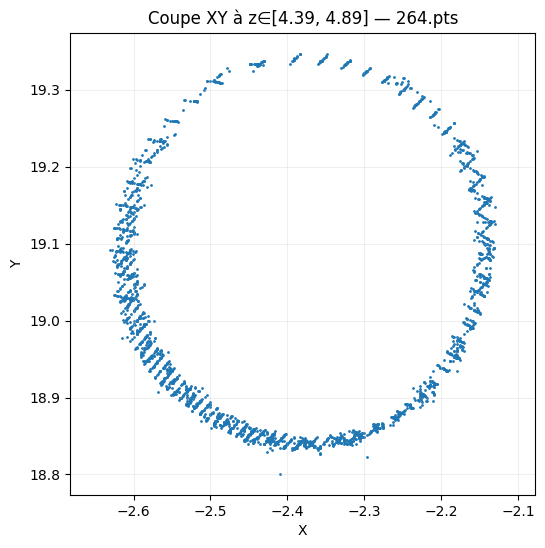

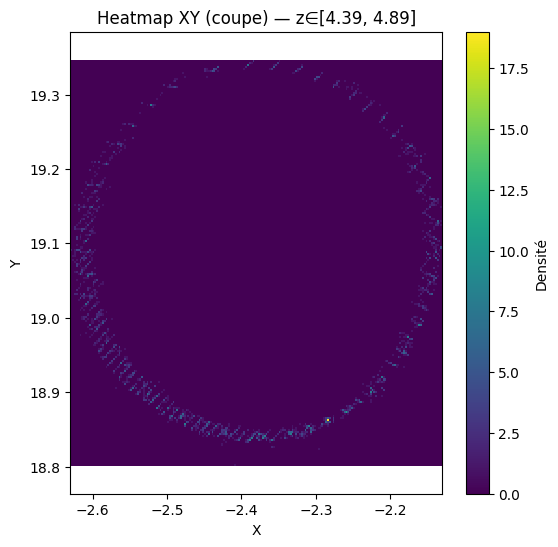

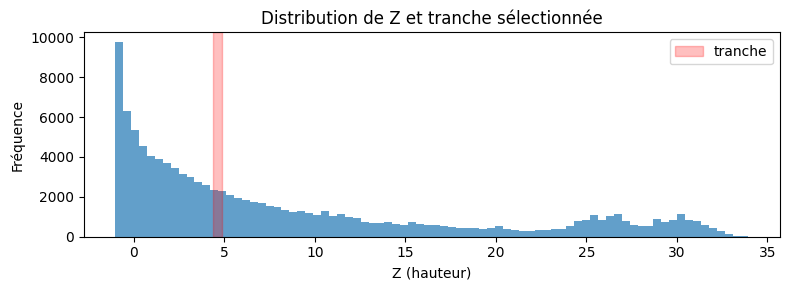

In [ ]:
# --- Cross-section 2D (plan XY) à une hauteur donnée ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Localiser un fichier .pts (adapte DATA_ROOT si besoin)
DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")
files = list(DATA_ROOT.rglob("*.pts"))
assert len(files) > 0, "Aucun .pts trouvé : vérifie DATA_ROOT et l'extension."
sample = files[0]   # ou choisis un autre index
print("Fichier utilisé :", sample)

# 2) Charger points (X,Y,Z)
points = np.loadtxt(sample)
assert points.shape[1] >= 3, "Le fichier doit contenir au moins 3 colonnes (X,Y,Z)."
x, y, z = points[:,0], points[:,1], points[:,2]

# 3) Paramètres de coupe
#    - z0 : hauteur centrale de la tranche
#    - dz : demi-épaisseur de la tranche (épaisseur totale = 2*dz)
#    ➜ Modifie ces deux valeurs selon ton besoin
z_min, z_max = float(np.min(z)), float(np.max(z))
z0 = np.median(z)        # ex : prendre la médiane comme coupe par défaut
dz = 0.25                # ex : tranche de 0.5 m d'épaisseur (±0.25)

# 4) Masque de sélection de la tranche
mask = (z >= (z0 - dz)) & (z <= (z0 + dz))
slice_pts = points[mask]
print(f"Hauteur cible z0={z0:.2f} | épaisseur totale={2*dz:.2f} | points retenus={slice_pts.shape[0]}")

# 5) Visualisation 2D de la coupe (projection XY)
plt.figure(figsize=(6,6))
plt.scatter(slice_pts[:,0], slice_pts[:,1], s=1)
plt.title(f"Coupe XY à z∈[{z0-dz:.2f}, {z0+dz:.2f}] — {sample.name}")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(alpha=0.2)
plt.show()

# (Option) Heatmap de densité sur la même tranche (plus lisible si beaucoup de points)
plt.figure(figsize=(6,6))
plt.hist2d(slice_pts[:,0], slice_pts[:,1], bins=200)
plt.colorbar(label="Densité")
plt.title(f"Heatmap XY (coupe) — z∈[{z0-dz:.2f}, {z0+dz:.2f}]")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

# (Option) Aide visuelle : histogramme de Z avec la tranche marquée
plt.figure(figsize=(8,3))
plt.hist(z, bins=80, alpha=0.7)
plt.axvspan(z0-dz, z0+dz, color='red', alpha=0.25, label="tranche")
plt.title("Distribution de Z et tranche sélectionnée")
plt.xlabel("Z (hauteur)")
plt.ylabel("Fréquence")
plt.legend()
plt.tight_layout()
plt.show()


4️⃣ Downsampling (réduction et affichage 2D):

Fichier utilisé : /content/drive/MyDrive/trees_dataset/Dataset_/Ash/264.pts
Points initiaux: 109543
Points conservés: 5735  | Réduction x19.10  | Méthode: grid


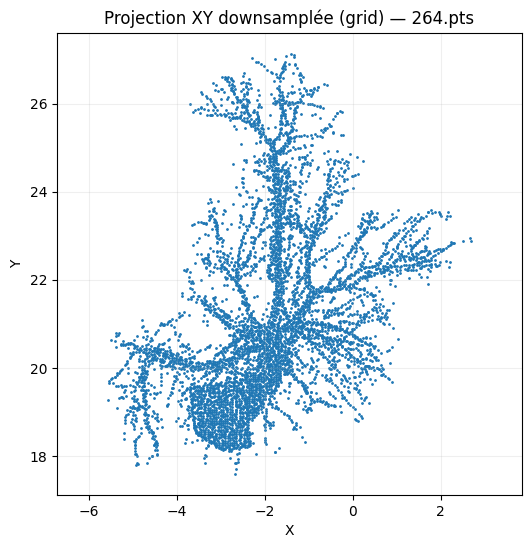

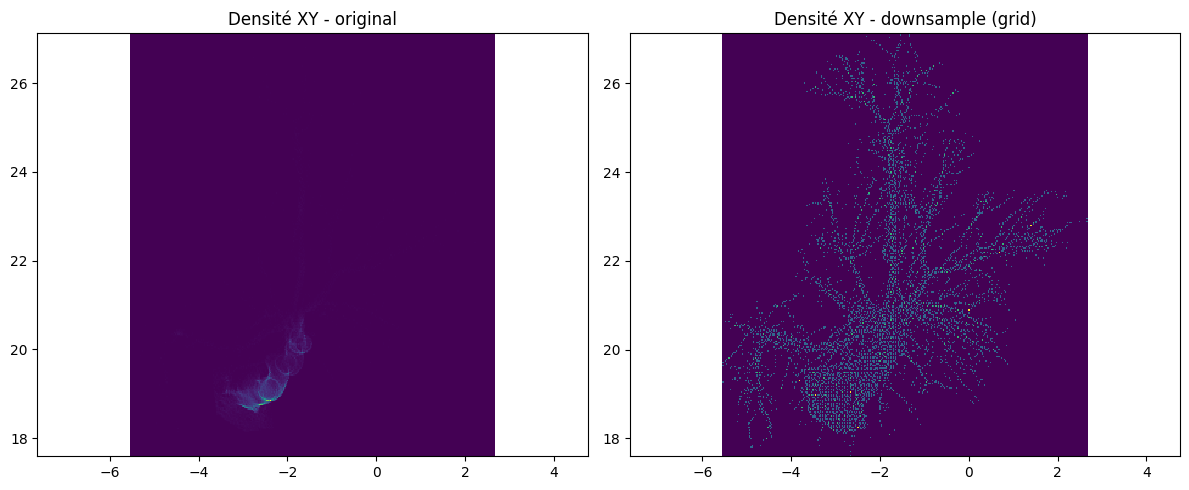

In [ ]:
# === Downsampling 2D (projection XY) : random / stride / grid (voxel) ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import open3d as o3d

# ---------- 1) Localiser un fichier ----------
DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")
EXTS = (".pts", ".xyz", ".xyzn", ".xyzrgb", ".txt", ".csv", ".ply", ".pcd")

files = []
for ext in EXTS:
    files += list(DATA_ROOT.rglob(f"*{ext}"))
assert files, "Aucun fichier trouvé : vérifie DATA_ROOT et les extensions."
sample = files[0]  # choisis un autre index si tu veux
print("Fichier utilisé :", sample)

# ---------- 2) Charger en (N,3) ----------
def load_points(path: Path) -> np.ndarray:
    suf = path.suffix.lower()
    if suf in {".ply", ".pcd"}:
        pcd = o3d.io.read_point_cloud(str(path))
        pts = np.asarray(pcd.points)  # (N,3)
    else:
        # lit les colonnes numériques; ignore entêtes atypiques
        pts = np.loadtxt(str(path), comments=("version:", "n_points:", "{", "}"))
        # garde au moins X,Y,Z
        if pts.ndim == 1:  # cas 1 ligne
            pts = pts[None, :]
        if pts.shape[1] < 3:
            raise ValueError("Le fichier doit contenir au moins 3 colonnes (X,Y,Z).")
    return pts[:, :3]

points = load_points(sample)
x, y, z = points[:,0], points[:,1], points[:,2]
N0 = len(points)
print(f"Points initiaux: {N0}")

# ---------- 3) Choisir la stratégie ----------
method = "grid"   # <- 'random' | 'stride' | 'grid'

# Paramètres communs / par méthode
frac = 0.1        # pour 'random' : fraction à garder (ex. 10%)
step = 10         # pour 'stride'  : garde 1 point / step
cell = 0.05       # pour 'grid'    : taille de cellule en unités XY (ex. 5 cm)

if method == "random":
    k = max(1, int(frac * N0))
    idx = np.random.choice(N0, size=k, replace=False)
    samp = points[idx]

elif method == "stride":
    samp = points[::step]

elif method == "grid":
    # Voxelisation 2D sur XY : 1 point par cellule (ici, premier point)
    # 1) Indices de cellule
    xmin, ymin = x.min(), y.min()
    ix = np.floor((x - xmin) / cell).astype(np.int64)
    iy = np.floor((y - ymin) / cell).astype(np.int64)
    # 2) Clés uniques par cellule
    keys = ix.astype(np.int64) << 32 | (iy.astype(np.int64) & 0xffffffff)
    # 3) Conserver le 1er index par cellule
    _, first_idx = np.unique(keys, return_index=True)
    samp = points[first_idx]

else:
    raise ValueError("method doit être 'random', 'stride' ou 'grid'.")

# ---------- 4) Affichage 2D (XY) ----------
N1 = len(samp)
print(f"Points conservés: {N1}  | Réduction x{N0/max(1,N1):.2f}  | Méthode: {method}")

plt.figure(figsize=(6,6))
plt.scatter(samp[:,0], samp[:,1], s=1)
plt.title(f"Projection XY downsamplée ({method}) — {sample.name}")
plt.xlabel("X"); plt.ylabel("Y")
plt.axis("equal"); plt.grid(alpha=0.2)
plt.show()

# (Option) Comparer avant/après en densité (utile si N0 est énorme)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist2d(x, y, bins=300)
plt.title("Densité XY - original")
plt.axis("equal")

plt.subplot(1,2,2)
plt.hist2d(samp[:,0], samp[:,1], bins=300)
plt.title(f"Densité XY - downsample ({method})")
plt.axis("equal")
plt.tight_layout()
plt.show()



> **Visualisations 3D**

1️⃣ Scatter 3D interactif

In [ ]:
# === Colab-safe 3D viz: Open3D (processing) + Plotly (display) ===
# 1) Fix versions
!pip -q install open3d==0.19.0 plotly

import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from pathlib import Path
from google.colab import drive

# 2) Mount & locate a real file
drive.mount('/content/drive', force_remount=False)
DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")
EXTS = (".ply", ".pcd", ".pts", ".xyz", ".xyzn", ".xyzrgb", ".txt", ".csv")

files = []
for ext in EXTS:
    files += list(DATA_ROOT.rglob(f"*{ext}"))
assert files, "Aucun fichier trouvé: vérifie DATA_ROOT et extensions."
sample = files[0]
print("Fichier utilisé:", sample)

# 3) Charge robuste: .ply/.pcd via Open3D, sinon loadtxt (ignore entêtes .pts)
def load_points_to_pcd(path: Path) -> o3d.geometry.PointCloud:
    suf = path.suffix.lower()
    if suf in {".ply", ".pcd"}:
        return o3d.io.read_point_cloud(str(path))
    arr = np.loadtxt(str(path), comments=("version:", "n_points:", "{", "}"))
    if arr.ndim == 1:
        arr = arr[None, :]
    assert arr.shape[1] >= 3, "Besoin d'au moins 3 colonnes (X,Y,Z)."
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(arr[:, :3])
    if arr.shape[1] >= 6:
        rgb = arr[:, 3:6]
        if rgb.max() > 1: rgb = rgb/255.0
        pcd.colors = o3d.utility.Vector3dVector(rgb[:, :3])
    return pcd

pcd = load_points_to_pcd(sample)
pts = np.asarray(pcd.points)
x, y, z = pts[:,0], pts[:,1], pts[:,2]
print(f"Points: {len(pts)} | X[{x.min():.2f},{x.max():.2f}] Y[{y.min():.2f},{y.max():.2f}] Z[{z.min():.2f},{z.max():.2f}]")

# 4) Plotly scatter3d (remplace z.ptp() par np.ptp(z))
def plotly_scatter3d(points, title="Scatter 3D", size=1, colors=None):
    if colors is None:
        z = points[:,2]
        zn = (z - z.min()) / (np.ptp(z) + 1e-12)  # <-- compat NumPy 2.0
        colors = zn
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(size=size, color=colors, colorscale='Viridis', opacity=0.9)
    )])
    fig.update_layout(title=title, scene_aspectmode='data', height=600)
    fig.show()

# A) Scatter 3D interactif (Plotly)
plotly_scatter3d(pts, title=f"Scatter 3D — {sample.name}", size=1)

# B) Voxelization 3D (downsample) + affichage
voxel_size = 0.10  # ajuste selon l’échelle
pcd_vox = pcd.voxel_down_sample(voxel_size=voxel_size)
pts_vox = np.asarray(pcd_vox.points)
print(f"Voxelisation: {len(pts)} -> {len(pts_vox)} points (voxel_size={voxel_size})")
plotly_scatter3d(pts_vox, title=f"Voxelized ({voxel_size} m) — {sample.name}", size=2)

# C) Coupe 3D (slice) — par Z
z0 = float(np.median(z))
dz  = 0.25
mask = (z >= (z0 - dz)) & (z <= (z0 + dz))
slice_pts = pts[mask]
print(f"Slice z∈[{z0-dz:.2f},{z0+dz:.2f}] -> {len(slice_pts)} points")
if len(slice_pts) > 0:
    plotly_scatter3d(slice_pts, title=f"Slice Z∈[{z0-dz:.2f},{z0+dz:.2f}] — {sample.name}", size=2)

# D) (Optionnel) Surface/mesh Poisson avec Plotly Mesh3D
# Si tu veux le mesh, décommente le bloc ci-dessous (peut être coûteux)
"""
pcd_n = o3d.geometry.PointCloud(pcd)
pcd_n.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30))
pcd_n.orient_normals_consistent_tangent_plane(30)

mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_n, depth=8)
bbox = pcd.get_axis_aligned_bounding_box()
mesh = mesh.crop(bbox)
mesh.compute_vertex_normals()

V = np.asarray(mesh.vertices)
F = np.asarray(mesh.triangles)
fig = go.Figure(data=[go.Mesh3d(
    x=V[:,0], y=V[:,1], z=V[:,2],
    i=F[:,0], j=F[:,1], k=F[:,2],
    opacity=1.0, color='lightgray'
)])
fig.update_layout(title=f"Poisson Mesh — {sample.name}", scene_aspectmode='data', height=600)
fig.show()
"""


2️⃣ Animation 3D (rotation automatique) — Plotly (sans OpenGL):

In [ ]:
# --- Animation 3D autour du point cloud (Plotly frames) ---
import numpy as np
import plotly.graph_objects as go

# Utilisons le point cloud downsamplé pcd (déjà chargé ci-dessus)
P = np.asarray(pcd.points)

# Scatter3D « base »
fig = go.Figure(data=[go.Scatter3d(
    x=P[:,0], y=P[:,1], z=P[:,2],
    mode='markers',
    marker=dict(size=1, color=(P[:,2]-P[:,2].min())/(np.ptp(P[:,2])+1e-12), colorscale='Viridis', opacity=0.9)
)])

fig.update_layout(scene_aspectmode='data', height=600)

# Générer des frames en faisant varier la caméra autour de l'axe Z
frames = []
R = 1.8  # distance caméra
for t in range(60):
    theta = 2*np.pi * t/60.0
    eye = dict(x=R*np.cos(theta), y=R*np.sin(theta), z=0.6*R)
    frames.append(go.Frame(layout=dict(scene_camera=dict(eye=eye))))

fig.update(frames=frames)
fig.update_layout(
    updatemenus=[dict(type="buttons",
                      showactive=False,
                      buttons=[dict(label="▶ Play", method="animate",
                                    args=[None, {"frame": {"duration": 50, "redraw": True},
                                                 "fromcurrent": True, "transition": {"duration": 0}}]),
                               dict(label="⏸ Pause", method="animate",
                                    args=[[None], {"frame": {"duration": 0, "redraw": False},
                                                   "mode":"immediate"}])])])

# Vue initiale
fig.update_layout(scene_camera=dict(eye=dict(x=R, y=0.0, z=0.6*R)))
fig.show()


Fichier choisi: /content/drive/MyDrive/trees_dataset/Dataset_/douglas_fir/61_20.txt


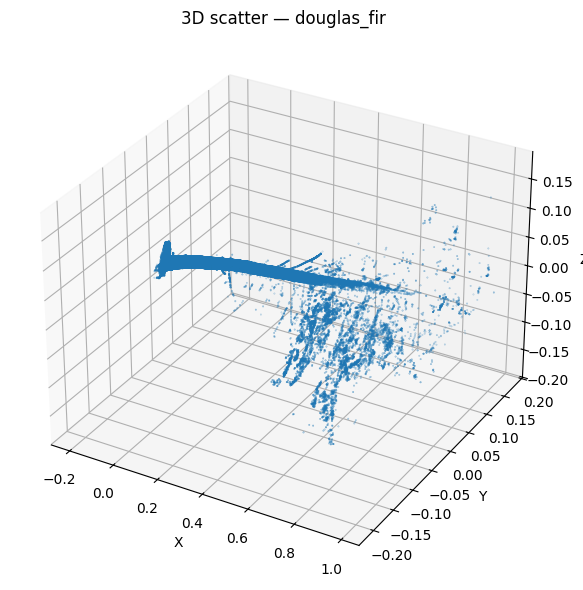

In [ ]:
# === Colab safe: visualize .pts (and txt/csv/xyz/ply/pcd) WITHOUT Open3D ===
from pathlib import Path
import re, random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)

# ----- CONFIG -----
DATA_ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")  # <-- adapte
READABLE_EXTS = {".pts", ".txt", ".csv", ".xyz", ".ply", ".pcd"}  # we'll only parse text ourselves; others via fallback
MAX_POINTS_3D = 120_000   # limite pour ne pas saturer la RAM/affichage
DOWNSAMPLE_2D = 200_000   # limite pour les scatter 2D

# ----- utils -----
def _fast_is_number(tok: str):
    return bool(re.match(r"^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$", tok))

def read_pts_like_text(path: Path):
    """
    Lit .pts/.txt/.csv/.xyz contenant X Y Z (≥3 colonnes).
    Ignore lignes vides/#// et en-tête 'N'.
    Détecte espace/tab/virgule automatiquement.
    """
    xs, ys, zs = [], [], []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first_non_comment = None
        for line in f:
            line = line.strip()
            if not line or line.startswith("#") or line.startswith("//"):
                continue
            if first_non_comment is None:
                toks = re.split(r"[,\s]+", line)
                if len(toks) == 1 and toks[0].isdigit():
                    first_non_comment = "header_count_skipped"
                    continue
                first_non_comment = "data"
            toks = re.split(r"[,\s]+", line)
            nums = [t for t in toks if _fast_is_number(t)]
            if len(nums) < 3:
                continue
            x, y, z = float(nums[0]), float(nums[1]), float(nums[2])
            xs.append(x); ys.append(y); zs.append(z)
    pts = np.column_stack([xs, ys, zs]).astype(np.float64)
    mask = np.isfinite(pts).all(axis=1)
    pts = pts[mask]
    if pts.size == 0:
        raise ValueError(f"Fichier vide/inexploitable: {path}")
    return pts

def reorient_with_pca(points):
    pts = points - points.mean(axis=0, keepdims=True)
    # SVD = PCA
    _,_,Vt = np.linalg.svd(pts, full_matrices=False)
    R = Vt.T
    pts_r = pts @ R
    if pts_r[:,2].mean() < 0:
        pts_r[:,2] *= -1
    return pts_r

def normalize_unit_sphere(points):
    c = points.mean(axis=0, keepdims=True)
    pts = points - c
    r = np.linalg.norm(pts, axis=1).max()
    return pts / (r + 1e-9)

def pick_any_sample(root: Path, exts):
    files = [f for f in root.rglob("*") if f.is_file() and f.suffix.lower() in exts]
    if not files:
        raise FileNotFoundError(f"Aucun fichier trouvé sous {root}")
    files.sort()
    return random.choice(files)

# ----- chargement d'un fichier -----
sample = pick_any_sample(DATA_ROOT, READABLE_EXTS)
cls = sample.parent.name
print("Fichier choisi:", sample)

# stratégie: on lit comme texte si .pts/.txt/.csv/.xyz; sinon on essaie numpy (XYZ simple)
ext = sample.suffix.lower()
if ext in {".pts", ".txt", ".csv", ".xyz"}:
    pts = read_pts_like_text(sample)
else:
    # fallback très simple: tenter numpy (fonctionnera si fichier est texte XYZ)
    try:
        arr = np.loadtxt(sample, dtype=float, delimiter=None)
    except Exception:
        arr = np.loadtxt(sample, dtype=float, delimiter=",")
    if arr.ndim != 2 or arr.shape[1] < 3:
        raise ValueError("Format non pris en charge sans Open3D. Convertis en .pts/.txt/.csv/.xyz (XYZ).")
    pts = arr[:, :3]

# pipeline "pro"
pts = reorient_with_pca(pts)
pts = normalize_unit_sphere(pts)

# downsample pour affichage
n = len(pts)
if n > DOWNSAMPLE_2D:
    idx = np.random.choice(n, DOWNSAMPLE_2D, replace=False)
    pts2d = pts[idx]
else:
    pts2d = pts



# ----- 3D Matplotlib (simple et sûr) -----
pts3d = pts if len(pts) <= MAX_POINTS_3D else pts[np.random.choice(len(pts), MAX_POINTS_3D, replace=False)]
fig3d = plt.figure(figsize=(6,6))
ax = fig3d.add_subplot(111, projection='3d')
ax.scatter(pts3d[:,0], pts3d[:,1], pts3d[:,2], s=0.1)
ax.set_title(f"3D scatter — {cls}")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.tight_layout(); plt.show()



*   **Fractionnement des données**


* **Prétraitement du dataset (avant génération des multi-vues**)


0) Imports & config

In [ ]:
import os, math, json, shutil
from pathlib import Path
import numpy as np

# Open3D 0.19 (ou récent)
import open3d as o3d

# ── CONFIG GLOBALE ─────────────────────────────────────────────
DATA_RAW = Path("/path/to/data_raw")        # racine des nuages bruts (7 dossiers d'espèces)
OUT_ROOT = Path("/path/to/output")          # racine des sorties
MV_SIZE  = (224, 224)                       # 224 x 224 pixels
K        = 8                                # nb de vues
VOXEL_M  = 0.05                             # downsample (mètres) ; None pour désactiver
REMOVE_OUTLIERS = True                      # nettoyage outliers
COLOR_BY_Z = True                           # coloriser par hauteur Z (pour injecter info)
RING_ELEV_DEG = 20                          # inclinaison du "ring-8" (pitch ≈ 20°)
CAM_RADIUS = 2.2                            # rayon caméra en coordonnées normalisées
BG_COLOR = (1.0, 1.0, 1.0, 1.0)             # fond blanc RGBA
SPECIES = ["Beech","Red_Oak","Ash","Oak","Douglas_Fir","Spruce","Pine"]


1) Lecture robuste des nuages de points

In [ ]:
def read_point_cloud_generic(path: Path) -> o3d.geometry.PointCloud:
    """
    Lecture .ply/.pcd avec Open3D ; .pts/.xyz/.txt/.csv via numpy.
    Attendu : X Y Z [R G B] [...] (si RGB, 0..255 ou 0..1)
    """
    ext = path.suffix.lower()
    pcd = None

    if ext in [".ply", ".pcd"]:
        pcd = o3d.io.read_point_cloud(str(path))
        if pcd.is_empty():
            raise ValueError(f"Empty point cloud: {path}")
        return pcd

    # fallback texte : .pts / .xyz / .txt / .csv
    arr = np.loadtxt(str(path), dtype=float, comments=["#", "//", "n"])
    if arr.ndim == 1:
        arr = arr.reshape(-1, 3)
    if arr.shape[1] < 3:
        raise ValueError(f"File has <3 columns: {path}")

    pts = arr[:, :3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)

    # couleurs si dispo
    if arr.shape[1] >= 6:
        rgb = arr[:, 3:6]
        if rgb.max() > 1.0:
            rgb = rgb / 255.0
        pcd.colors = o3d.utility.Vector3dVector(rgb)

    return pcd


2) Nettoyage (outliers) + downsample (voxel)

In [ ]:
def clean_and_downsample(pcd: o3d.geometry.PointCloud,
                         remove_outliers=True,
                         voxel_size: float | None = 0.05) -> o3d.geometry.PointCloud:
    q = pcd
    if remove_outliers:
        # outliers statistiques
        q, _ = q.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    if voxel_size and voxel_size > 0:
        q = q.voxel_down_sample(voxel_size)
    return q


3) Alignement de l’axe Z (PCA globale)

On aligne l’axe principal du tronc sur +Z.

In [ ]:
def align_to_Z_by_pca(pcd: o3d.geometry.PointCloud) -> o3d.geometry.PointCloud:
    pts = np.asarray(pcd.points)
    ctr = pts.mean(axis=0)
    X = pts - ctr
    C = np.cov(X.T)
    vals, vecs = np.linalg.eigh(C)          # vecs[:,i] eigenvector
    # axe principal = vecteur propre de plus grande valeur
    idx = np.argsort(vals)[::-1]
    v1 = vecs[:, idx[0]]                    # direction longueur max
    # on veut v1 aligné avec +Z
    z = np.array([0., 0., 1.])
    # calcul rotation qui amène v1 -> z
    v = np.cross(v1, z)
    s = np.linalg.norm(v)
    c = float(np.dot(v1, z))
    if s < 1e-8:  # déjà aligné (ou opposé)
        R = np.eye(3) if c > 0 else np.diag([1, -1, -1])
    else:
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        R = np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))
    Y = (R @ X.T).T + ctr

    out = o3d.geometry.PointCloud()
    out.points = o3d.utility.Vector3dVector(Y)
    if pcd.has_colors():
        out.colors = pcd.colors
    return out


4) Mesures réelles (avant normalisation)

In [ ]:
def real_measures(pcd: o3d.geometry.PointCloud) -> dict:
    pts = np.asarray(pcd.points)
    xmin, ymin, zmin = pts.min(axis=0)
    xmax, ymax, zmax = pts.max(axis=0)
    Lx = xmax - xmin
    Ly = ymax - ymin
    H  = zmax - zmin
    V  = Lx * Ly * H
    ratios = {
        "H_over_maxLW": H / max(Lx, Ly) if max(Lx, Ly) > 0 else 0.0,
        "Lx_over_Ly": Lx / Ly if Ly > 0 else 0.0
    }
    return {"Lx": float(Lx), "Ly": float(Ly), "H": float(H), "AABB_volume": float(V), **ratios}


5) Normalisation AABB (centrage + échelle isotrope)

In [ ]:
def normalize_aabb(pcd: o3d.geometry.PointCloud, margin=0.0):
    pts = np.asarray(pcd.points).copy()
    mins = pts.min(axis=0); maxs = pts.max(axis=0)
    ctr  = (mins + maxs) / 2.0
    ext  = (maxs - mins)
    L    = float(ext.max())
    s    = L * (1.0 + margin) if L > 0 else 1.0
    ptsn = (pts - ctr) / s

    out = o3d.geometry.PointCloud()
    out.points = o3d.utility.Vector3dVector(ptsn)
    if pcd.has_colors():
        out.colors = pcd.colors
    return out, ctr, s


In [41]:
from pathlib import Path
import open3d as o3d
import json

# ==============================
# CONFIGURATION
# ==============================
ROOT = Path("/content/drive/MyDrive/trees_dataset/")   # 📌 ton dossier racine
TRAIN_DIR = ROOT / "dataset_train"                     # 📌 adapte au vrai nom dans Drive
TEST_DIR  = ROOT / "dataset_test"                      # 📌 idem
OUT_DIR   = ROOT / "data_preprocessed"                 # sortie prétraitée
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("📂 TRAIN_DIR:", TRAIN_DIR.exists())
print("📂 TEST_DIR :", TEST_DIR.exists())

# ==============================
# PIPELINE PRÉTRAITEMENT (fonctions déjà définies)
# ==============================
def process_split(split_dir: Path, out_split: Path):
    out_split.mkdir(parents=True, exist_ok=True)

    for cls_dir in split_dir.iterdir():
        if not cls_dir.is_dir():
            continue

        out_cls = out_split / cls_dir.name
        out_cls.mkdir(parents=True, exist_ok=True)

        for f in cls_dir.glob("*"):
            if not f.suffix.lower() in [".ply", ".pcd", ".pts", ".xyz", ".txt", ".csv"]:
                continue
            try:
                # 1) lecture
                pcd = read_point_cloud_generic(f)
                # 2) nettoyage/downsample
                pcd = clean_and_downsample(pcd)
                # 3) alignement Z
                pcd = align_to_Z_by_pca(pcd)
                # 4) mesures réelles
                measures = real_measures(pcd)
                # 5) normalisation AABB
                pcd_norm, ctr, scale = normalize_aabb(pcd)

                # sauvegarde nuage normalisé
                out_path = out_cls / f"{f.stem}_norm.ply"
                o3d.io.write_point_cloud(str(out_path), pcd_norm)

                # sauvegarde métadonnées
                meta_path = out_cls / f"{f.stem}_meta.json"
                with open(meta_path, "w") as fp:
                    json.dump({
                        "file": f.name,
                        "class": cls_dir.name,
                        "measures": measures,
                        "center": ctr.tolist(),
                        "scale": float(scale)
                    }, fp, indent=2)

                print(f"✅ {f.name} prétraité → {out_path.name}")

            except Exception as e:
                print(f"⚠️ Erreur {f}: {e}")

# ==============================
# LANCEMENT
# ==============================
process_split(TRAIN_DIR, OUT_DIR / "train")
process_split(TEST_DIR,  OUT_DIR / "test")

print("🎯 Prétraitement terminé.")


📂 TRAIN_DIR: True
📂 TEST_DIR : True
✅ 65_11.txt prétraité → 65_11_norm.ply
✅ 65_8.txt prétraité → 65_8_norm.ply
✅ 65_86.txt prétraité → 65_86_norm.ply
✅ 65_65.txt prétraité → 65_65_norm.ply
✅ 65_38.txt prétraité → 65_38_norm.ply
✅ 64_14.txt prétraité → 64_14_norm.ply
✅ 64_16.txt prétraité → 64_16_norm.ply
✅ 34_23.txt prétraité → 34_23_norm.ply
✅ 35_78.txt prétraité → 35_78_norm.ply
✅ 65_17.txt prétraité → 65_17_norm.ply
✅ 65_13.txt prétraité → 65_13_norm.ply
✅ 35_68.txt prétraité → 35_68_norm.ply
✅ 35_77.txt prétraité → 35_77_norm.ply
✅ 65_22.txt prétraité → 65_22_norm.ply
✅ 64_50_2.txt prétraité → 64_50_2_norm.ply
✅ 64_67.txt prétraité → 64_67_norm.ply
✅ 65_82.txt prétraité → 65_82_norm.ply
✅ 65_25.txt prétraité → 65_25_norm.ply
✅ 35_82.txt prétraité → 35_82_norm.ply
✅ 35_72.txt prétraité → 35_72_norm.ply
✅ 65_36.txt prétraité → 65_36_norm.ply
✅ 35_90.txt prétraité → 35_90_norm.ply
✅ 35_32.txt prétraité → 35_32_norm.ply
✅ 35_60.txt prétraité → 35_60_norm.ply
✅ 65_39.txt prétraité → 65


3. **Classification Methods**



3.1 Méthodes indirectes : Approches multi-vues

Choix du nombre de vues (K) dans l’**approche multi-vues**:

L’approche multi-vues consiste à projeter un nuage de points 3D sous plusieurs angles de vue prédéfinis afin de générer un ensemble d’images 2D représentatives de l’objet. L’idée est de transformer un problème de classification 3D, complexe et coûteux, en un problème plus classique de reconnaissance d’images 2D, pour lequel les méthodes d’apprentissage profond sont particulièrement performantes.

Chaque arbre est donc représenté par K images issues de rotations régulières autour de son axe vertical. Ces images sont ensuite traitées soit par des descripteurs classiques (tels que SIFT, HOG ou LBP) combinés à des classifieurs traditionnels (SVM, régression logistique, etc.), soit par des réseaux de neurones convolutionnels (CNN), entraînés de zéro ou fine-tunés à partir de modèles pré-entraînés sur ImageNet.

Cette stratégie présente deux avantages principaux :

elle permet de réutiliser l’écosystème existant des méthodes 2D (bibliothèques, modèles pré-entraînés, pipelines robustes),

elle offre une représentation riche et discriminante de la structure de l’arbre en agrégeant plusieurs vues complémentaires.

Un aspect crucial de cette méthode réside dans le choix du nombre de vues (K) : trop peu de vues risquent de ne pas capturer suffisamment d’information géométrique, tandis qu’un trop grand nombre augmente fortement le coût en calcul et introduit de la redondance. Dans ce projet, nous avons donc comparé plusieurs valeurs de K (4, 8, 12, 16) afin de déterminer le compromis optimal entre précision et complexité.

In [43]:
# =========================
# A) CONFIG & DATA LOADING
# =========================
import os, re, numpy as np, pandas as pd
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")   # <-- adapte
TRAIN_DIR = ROOT / "dataset_train"
TEST_DIR  = ROOT / "dataset_test"
assert TRAIN_DIR.is_dir() and TEST_DIR.is_dir(), "Vérifie dataset_train/ et dataset_test/"

# --- Hyperparamètres globaux ---
V_CANDIDATES = [4, 8, 12, 16]          # nombres de vues à tester
IMG_SIZE     = 32                      # passe à 64 pour mieux apprendre (plus de temps/mémoire)
CHANNELS     = 2                       # 1=depth, 2=depth+mask (recommandé)
K_FOLDS      = 3
BASE_CH      = 16                      # augmente à 32 si IMG_SIZE=64
EPOCHS       = 30
BATCH_SIZE   = 16
POOLING      = "avg"                   # "avg" ou "max" (avg souvent plus stable)
WD_L2        = 1e-4

# --- Essaie de réutiliser des tenseurs pré-calculés (samples1/samples2) ---
X_train_full = globals().get("samples1", None)
y_train_full = globals().get("labels",   None)
X_test_full  = globals().get("samples2", None)
y_test_full  = globals().get("val_labels", None)

def is_pc_file(p: Path): return p.suffix.lower() in {".pts",".xyz",".txt",".ply"}

# Si on n'a pas les tenseurs, on les reconstruit depuis disque
if X_train_full is None:
    # ---------- utilitaires nuage->multi-vues (identiques à ceux donnés précédemment) ----------
    def load_point_cloud_txt(path: Path):
        pts=[]
        with open(path,"r",errors="ignore") as f:
            for line in f:
                sp=line.strip().split()
                if len(sp)<3: continue
                try:
                    pts.append([float(sp[0]),float(sp[1]),float(sp[2])])
                except: pass
        pts=np.asarray(pts,dtype=np.float32)
        if pts.size:
            pts-=pts.mean(axis=0,keepdims=True)
            m=np.abs(pts).max()
            if m>0: pts/=m
            pts=(pts+1.0)*0.5
            pts=np.clip(pts,0.0,1.0)
        return pts

    def point_cloud_to_volume(points, size=32):
        vol=np.zeros((size,size,size),dtype=np.uint8)
        if points.size==0: return vol
        loc=(points*(size-1)).astype(int)
        loc=np.clip(loc,0,size-1)
        vol[loc[:,0],loc[:,1],loc[:,2]]=1
        return vol

    def vol2depth_and_mask(volume_array):
        depth = np.argmax(volume_array, axis=2).astype(np.float32)  # 0..S-1
        mask  = (volume_array.sum(axis=2)>0).astype(np.float32)
        depth = depth / (volume_array.shape[2]-1 + 1e-8)            # [0,1]
        return depth, mask

    def rot_mat_z(deg):
        rad=np.radians(deg); c,s=np.cos(rad),np.sin(rad)
        return np.asarray([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)

    def rotate_cloud_unit(points, deg):
        if points.size==0: return points
        P=(points-0.5) @ rot_mat_z(deg).T
        P=(P+0.5)
        return np.clip(P,0.0,1.0)

    def make_multiview(points, V=12, size=32, channels=2):
        views=[]
        step = max(1, 360//V)
        for k in range(V):
            deg=k*step
            pc_rot=rotate_cloud_unit(points,deg)
            vol=point_cloud_to_volume(pc_rot,size=size)
            depth,mask=vol2depth_and_mask(vol)
            if channels==2:
                views.append(np.stack([depth,mask],axis=-1))  # (H,W,2)
            else:
                views.append(depth[...,None])                  # (H,W,1)
        return np.stack(views,axis=0)  # (V,H,W,C)

    # classes d'après le train
    CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
    CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}
    print("Classes:", CLASS_NAMES)

    def build_split_arrays(split_dir: Path, V=12, size=32, channels=2):
        X,Y=[],[]
        for cls in CLASS_NAMES:
            cdir=split_dir/cls
            if not cdir.is_dir(): continue
            files=[p for p in sorted(cdir.iterdir()) if p.is_file() and is_pc_file(p)]
            for fp in files:
                pts=load_point_cloud_txt(fp)
                views=make_multiview(pts,V=V,size=size,channels=channels)
                X.append(views); Y.append(CLASS_TO_ID[cls])
        if not X:
            return np.zeros((0,V,size,size,channels),dtype=np.float32), np.zeros((0,),dtype=np.int64)
        return np.asarray(X,dtype=np.float32), np.asarray(Y,dtype=np.int64)

    # on calcule à V= max(V_CANDIDATES) pour pouvoir sous-échantillonner ensuite
    V_MAX = max(V_CANDIDATES)
    X_train_full, y_train_full = build_split_arrays(TRAIN_DIR, V=V_MAX, size=IMG_SIZE, channels=CHANNELS)
    X_test_full,  y_test_full  = build_split_arrays(TEST_DIR,  V=V_MAX, size=IMG_SIZE, channels=CHANNELS)
    CLASS_NAMES = sorted(set([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()]))
else:
    # on suppose que samples1/samples2 sont (N,V,H,W,C) déjà en [0,1]
    CLASS_NAMES = globals().get("CLASS_NAMES", None)
    if CLASS_NAMES is None:
        # déduire depuis dossiers train
        CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])

num_classes = len(CLASS_NAMES)
print("Shapes:", X_train_full.shape, y_train_full.shape, X_test_full.shape, y_test_full.shape)
print("Nb classes:", num_classes, " -> ", CLASS_NAMES)

# helper: choisir v vues régulièrement espacées à partir de V_MAX
def pick_views(x, v):
    V = x.shape[1]
    if v>=V: return x
    step = V / v
    idx = [int(round(i*step)) % V for i in range(v)]
    return x[:, idx]

# =========================
# B) MODÈLE MVCNN & UTILS
# =========================
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

def build_shared_cnn(img_rows, img_cols, in_ch=1, base_ch=16, wd=1e-4):
    reg = regularizers.l2(wd)
    m = models.Sequential(name="shared_cnn")
    m.add(layers.Input(shape=(img_rows,img_cols,in_ch)))
    m.add(layers.Conv2D(base_ch,3,activation='relu',padding='same',kernel_regularizer=reg))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(base_ch,3,activation='relu',padding='same',kernel_regularizer=reg))
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(base_ch*2,3,activation='relu',padding='same',kernel_regularizer=reg))
    m.add(layers.BatchNormalization())
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
    return m

class SplitLayer(layers.Layer):
    def __init__(self, n, **kw): super().__init__(**kw); self.n=int(n)
    def call(self, x): return [x[:,i] for i in range(self.n)]
    def get_config(self): return {"n": self.n, **super().get_config()}

def build_mvcnn(num_views, num_classes, img_rows, img_cols, in_ch=1, base_ch=16, view_pooling="avg", wd=1e-4):
    shared = build_shared_cnn(img_rows,img_cols,in_ch,base_ch,wd)
    inp = layers.Input(shape=(num_views,img_rows,img_cols,in_ch))
    views = SplitLayer(num_views)(inp)
    feats = [shared(v) for v in views]
    fused = layers.Average(name="views_avg")(feats) if view_pooling=="avg" else layers.Maximum(name="views_max")(feats)
    x = layers.Dropout(0.30)(fused)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.50)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out, name=f"MVCNN_{view_pooling}")

# =========================
# C) SWEEP SUR V ∈ V_CANDIDATES AVEC K-FOLD SUR TRAIN
# =========================
results = []  # (V, fold, acc, f1)
IMG_H, IMG_W, IN_CH = X_train_full.shape[2], X_train_full.shape[3], X_train_full.shape[4]

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for V in V_CANDIDATES:
    # sous-échantillonne les vues
    XtrV = pick_views(X_train_full, V)
    print(f"\n=== V = {V} vues | train shape: {XtrV.shape} ===")
    for fold, (idx_tr, idx_va) in enumerate(skf.split(XtrV, y_train_full), start=1):
        x_tr, x_va = XtrV[idx_tr], XtrV[idx_va]
        y_tr, y_va = y_train_full[idx_tr], y_train_full[idx_va]

        ytr_oh = to_categorical(y_tr, num_classes)
        yva_oh = to_categorical(y_va, num_classes)

        # class weights (déséquilibre)
        classes = np.unique(y_tr)
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
        class_weight = {int(c): float(w) for c,w in zip(classes, cw)}

        model = build_mvcnn(num_views=V, num_classes=num_classes,
                            img_rows=IMG_H, img_cols=IMG_W, in_ch=IN_CH,
                            base_ch= BASE_CH, view_pooling=POOLING, wd=WD_L2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
            metrics=['accuracy']
        )
        cbs=[
            callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
            callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
        ]

        model.fit(x_tr, ytr_oh,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_va, yva_oh),
                  class_weight=class_weight,
                  verbose=0, callbacks=cbs)

        # métriques fold
        y_pred = model.predict(x_va, verbose=0).argmax(axis=1)
        acc = float(accuracy_score(y_va, y_pred))
        f1m = float(f1_score(y_va, y_pred, average="macro"))
        results.append({"V":V, "fold":fold, "val_acc":acc, "val_f1_macro":f1m})
        print(f"Fold {fold}/{K_FOLDS} → acc={acc:.3f} | F1(macro)={f1m:.3f}")

# récapitulatif
res_df = pd.DataFrame(results)
print("\n=== Résultats K-Fold (validation) ===")
print(res_df.groupby("V")[["val_acc","val_f1_macro"]].agg(["mean","std"]).round(3))

# =========================
# D) (OPTION) TEST FINAL SUR JEU FIXE
# =========================
# Choisir V* qui maximise la moyenne F1 macro en validation
best_V = (res_df.groupby("V")["val_f1_macro"].mean().idxmax()
          if len(res_df) else V_CANDIDATES[-1])
print(f"\nV optimal (selon F1 macro moyenne en K-fold) = {best_V}")

# Entraîner sur TOUT le train (avec V*) et évaluer sur test fixe
XtrV = pick_views(X_train_full, best_V)
XteV = pick_views(X_test_full,  best_V)
ytr_oh = to_categorical(y_train_full, num_classes)
yte_oh = to_categorical(y_test_full,  num_classes)

# class weights sur tout le train
classes = np.unique(y_train_full)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_full)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}

final_model = build_mvcnn(best_V, num_classes, IMG_H, IMG_W, IN_CH, base_ch=BASE_CH, view_pooling=POOLING, wd=WD_L2)
final_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                    metrics=['accuracy'])
final_model.fit(XtrV, ytr_oh, batch_size=BATCH_SIZE, epochs=EPOCHS,
                validation_split=0.1, class_weight=class_weight,
                callbacks=[
                    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
                    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
                ],
                verbose=0)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = final_model.predict(XteV, verbose=0).argmax(axis=1)
test_acc = accuracy_score(y_test_full, y_pred)
test_f1m = f1_score(y_test_full, y_pred, average="macro")
print(f"\n=== TEST FINAL (V={best_V}) ===")
print(f"Accuracy: {test_acc:.3f} | Macro-F1: {test_f1m:.3f}")

# (facultatif) Rapport détaillé + matrice de confusion
print("\nClassification report:")
print(classification_report(y_test_full, y_pred, target_names=CLASS_NAMES, digits=3))

import seaborn as sn
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_full, y_pred, labels=list(range(num_classes)))
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
plt.figure(figsize=(8,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (Test) – V={best_V}")
plt.ylabel("Vrai"); plt.xlabel("Prédit")
plt.show()


AssertionError: Vérifie dataset_train/ et dataset_test/

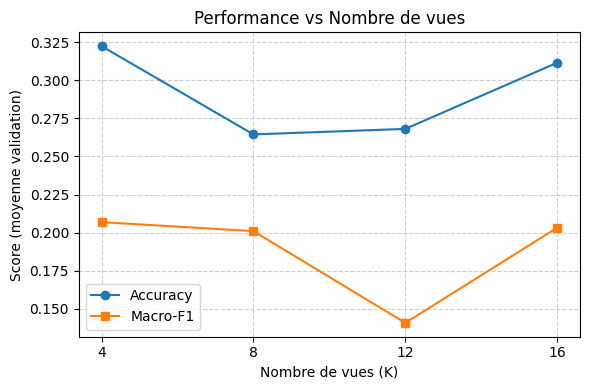

In [ ]:
import matplotlib.pyplot as plt

# Calculer la moyenne par nombre de vues
agg = res_df.groupby("V")[["val_acc","val_f1_macro"]].mean().reset_index()

plt.figure(figsize=(6,4))
plt.plot(agg["V"], agg["val_acc"], marker="o", label="Accuracy")
plt.plot(agg["V"], agg["val_f1_macro"], marker="s", label="Macro-F1")

plt.xlabel("Nombre de vues (K)")
plt.ylabel("Score (moyenne validation)")
plt.title("Performance vs Nombre de vues")
plt.xticks(agg["V"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


rekia - multiview, pretraitement

In [44]:
# === 1) Monter Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import open3d as o3d
import numpy as np
import os

# === 2) Fonction pour charger les points 3D ===
def try_load_points(file_path):
    try:
        with open(file_path, "r") as f:
            first_line = f.readline().strip().split()
            if len(first_line) < 3:
                return None
            for val in first_line[:3]:
                try:
                    float(val)
                except ValueError:
                    return None
        points = np.loadtxt(file_path)
        if points.ndim == 1:
            points = points.reshape(1, -1)
        return points[:, :3]
    except:
        return None

# === 3) Générer 8 vues par objet avec OffscreenRenderer ===
def generate_multiviews(points, output_folder, base_name, num_views=8, image_size=512):
    # Créer la point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Rendu hors écran
    renderer = o3d.visualization.rendering.OffscreenRenderer(image_size, image_size)
    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLit"
    renderer.scene.add_geometry("pcd", pcd, mat)

    center = pcd.get_center()
    radius = np.linalg.norm(np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound())) / 2
    camera = renderer.scene.camera

    for i in range(num_views):
        angle = 360 / num_views * i
        # Calculer la position de la caméra en cercle autour de l’objet
        cam_pos = center + radius * np.array([np.cos(np.radians(angle)), 0, np.sin(np.radians(angle))])
        camera.look_at(center, cam_pos, [0, 1, 0])

        # Capturer l'image
        img = renderer.render_to_image()
        img_path = os.path.join(output_folder, f"{base_name}_view{i+1}.png")
        o3d.io.write_image(img_path, img)

    renderer.release()

# === 4) Paramètres dataset ===
root_input = "/content/drive/MyDrive/trees_dataset/data_preprocessed/test"
root_output = "/content/drive/MyDrive/trees_dataset/MultiView_test"
species_list = ["Beech", "Red_Oak", "Ash", "Oak", "Douglas_Fir", "Spruce", "Pine"]
num_views = 8
valid_ext = [".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".txt", ".csv"]

# === 5) Boucle principale ===
for species in species_list:
    in_dir = os.path.join(root_input, species)
    out_dir = os.path.join(root_output, f"{species}_{num_views}views")
    os.makedirs(out_dir, exist_ok=True)

    if not os.path.exists(in_dir):
        print(f"⚠️ Dossier introuvable: {in_dir}")
        continue

    for file_name in os.listdir(in_dir):
        if os.path.splitext(file_name)[1].lower() in valid_ext:
            file_path = os.path.join(in_dir, file_name)
            points = try_load_points(file_path)
            if points is not None:
                base_name = os.path.splitext(file_name)[0]
                generate_multiviews(points, out_dir, base_name, num_views)

print("✅ Génération terminée : 8 vues par objet enregistrées dans Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Génération terminée : 8 vues par objet enregistrées dans Drive


In [45]:
# === 1) Monter Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 2) Fonction pour charger les points 3D ===
def try_load_points(file_path):
    try:
        ext = os.path.splitext(file_path)[1].lower()
        if ext in [".ply", ".pcd", ".xyzrgb", ".xyzn"]:
            pcd = o3d.io.read_point_cloud(file_path)
            return np.asarray(pcd.points)
        else:  # .xyz, .txt, .csv
            points = np.loadtxt(file_path)
            if points.ndim == 1:
                points = points.reshape(1, -1)
            return points[:, :3]
    except Exception as e:
        print(f"⚠️ Erreur lecture {file_path}: {e}")
        return None

# === 3) Générer 8 vues par objet avec Matplotlib ===
def generate_multiviews(points, output_folder, base_name, num_views=8, image_size=512):
    center = points.mean(axis=0)
    radius = np.linalg.norm(points.max(axis=0) - points.min(axis=0)) / 2

    for i in range(num_views):
        angle = 360 / num_views * i
        fig = plt.figure(figsize=(image_size/100, image_size/100), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c='green')

        # Ajuster la vue
        ax.view_init(elev=20, azim=angle)
        ax.set_axis_off()
        ax.set_xlim(center[0]-radius, center[0]+radius)
        ax.set_ylim(center[1]-radius, center[1]+radius)
        ax.set_zlim(center[2]-radius, center[2]+radius)

        img_path = os.path.join(output_folder, f"{base_name}_view{i+1}.png")
        plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
        plt.close()

# === 4) Paramètres dataset ===
root_input = "/content/drive/MyDrive/trees_dataset/data_preprocessed/test"
root_output = "/content/drive/MyDrive/trees_dataset/MultiView_test"
species_list = ["Beech", "Red_Oak", "Ash", "Oak", "Douglas_Fir", "Spruce", "Pine"]
num_views = 8
valid_ext = [".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".txt", ".csv"]

# === 5) Boucle principale ===
for species in species_list:
    in_dir = os.path.join(root_input, species)
    out_dir = os.path.join(root_output, f"{species}_{num_views}views")
    os.makedirs(out_dir, exist_ok=True)

    if not os.path.exists(in_dir):
        print(f"⚠️ Dossier introuvable: {in_dir}")
        continue

    for file_name in os.listdir(in_dir):
        if os.path.splitext(file_name)[1].lower() in valid_ext:
            file_path = os.path.join(in_dir, file_name)
            points = try_load_points(file_path)
            if points is not None and len(points) > 0:
                base_name = os.path.splitext(file_name)[0]
                generate_multiviews(points, out_dir, base_name, num_views)

print("✅ Génération terminée : 8 vues par objet enregistrées dans Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Génération terminée : 8 vues par objet enregistrées dans Drive


# **Train 8views**

In [ ]:
# === 1) Monter Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 2) Fonction pour charger les points 3D ===
def try_load_points(file_path):
    try:
        ext = os.path.splitext(file_path)[1].lower()
        if ext in [".ply", ".pcd", ".xyzrgb", ".xyzn"]:
            pcd = o3d.io.read_point_cloud(file_path)
            return np.asarray(pcd.points)
        else:  # .xyz, .txt, .csv
            points = np.loadtxt(file_path)
            if points.ndim == 1:
                points = points.reshape(1, -1)
            return points[:, :3]
    except Exception as e:
        print(f"⚠️ Erreur lecture {file_path}: {e}")
        return None

# === 3) Générer 8 vues par objet avec Matplotlib ===
def generate_multiviews(points, output_folder, base_name, num_views=8, image_size=512):
    center = points.mean(axis=0)
    radius = np.linalg.norm(points.max(axis=0) - points.min(axis=0)) / 2

    for i in range(num_views):
        angle = 360 / num_views * i
        fig = plt.figure(figsize=(image_size/100, image_size/100), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c='green')

        # Ajuster la vue
        ax.view_init(elev=20, azim=angle)
        ax.set_axis_off()
        ax.set_xlim(center[0]-radius, center[0]+radius)
        ax.set_ylim(center[1]-radius, center[1]+radius)
        ax.set_zlim(center[2]-radius, center[2]+radius)

        img_path = os.path.join(output_folder, f"{base_name}_view{i+1}.png")
        plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
        plt.close()

# === 4) Paramètres dataset ===
root_input = "/content/drive/MyDrive/trees_dataset/data_preprocessed/train"
root_output = "/content/drive/MyDrive/trees_dataset/MultiView_train"
species_list = ["Beech", "Red_Oak", "Ash", "Oak", "Douglas_Fir", "Spruce", "Pine"]
num_views = 8
valid_ext = [".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".txt", ".csv"]

# === 5) Boucle principale ===
for species in species_list:
    in_dir = os.path.join(root_input, species)
    out_dir = os.path.join(root_output, f"{species}_{num_views}views")
    os.makedirs(out_dir, exist_ok=True)

    if not os.path.exists(in_dir):
        print(f"⚠️ Dossier introuvable: {in_dir}")
        continue

    for file_name in os.listdir(in_dir):
        if os.path.splitext(file_name)[1].lower() in valid_ext:
            file_path = os.path.join(in_dir, file_name)
            points = try_load_points(file_path)
            if points is not None and len(points) > 0:
                base_name = os.path.splitext(file_name)[0]
                generate_multiviews(points, out_dir, base_name, num_views)

print("✅ Génération terminée : 8 vues par objet enregistrées dans Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
